In [ ]:
# Install `transformers` from master
%pip install git+https://github.com/huggingface/transformers
%pip list | grep -E 'transformers|tokenizers'
# transformers version at notebook update --- 2.11.0
# tokenizers version at notebook update --- 0.8.0rc1

In [1]:
from tokenizers.implementations import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing


tokenizer = ByteLevelBPETokenizer(
    "BPEtokenizer/vocab.json",
    "BPEtokenizer/merges.txt",
)

In [2]:
tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>")),
)
tokenizer.enable_truncation(max_length=512)

In [3]:
from transformers import RobertaConfig

config = RobertaConfig(
    vocab_size=50_000,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
)

In [4]:
from transformers import RobertaTokenizerFast

tokenizer = RobertaTokenizerFast.from_pretrained("BPEtokenizer", max_len=512)

In [5]:
from transformers import RobertaForMaskedLM

model = RobertaForMaskedLM(config=config)

In [6]:
model.num_parameters()
# => 84 million parameters

81966416

In [7]:
from datasets import load_dataset
dataset = load_dataset("text", data_files="data/unlabeled_data_sentences.txt", split='train') #, split='train', streaming=True)
# dataset = load_dataset("text", data_files=r"..\ttmp\unlabeled_data_sentences.txt", split='train').shuffle()
dataset

Found cached dataset text (C:/Users/Jonathan Ipe/.cache/huggingface/datasets/text/default-380bcce244e545de/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


Dataset({
    features: ['text'],
    num_rows: 28046
})

In [8]:
dataset = dataset.train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 22436
    })
    test: Dataset({
        features: ['text'],
        num_rows: 5610
    })
})

In [9]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding='max_length', max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/22436 [00:00<?, ? examples/s]

Map:   0%|          | 0/5610 [00:00<?, ? examples/s]

In [10]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 22436
    })
    test: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 5610
    })
})

In [11]:
train_dataset = tokenized_datasets['train']
val_dataset = tokenized_datasets['test']

In [12]:
# # Splitting the dataset
# train_dataset_size = 1000  # Specify the number of training data points
# val_dataset_size = 250    # Specify the number of validation data points

# train_dataset = tokenized_datasets.take(train_dataset_size)
# val_dataset = tokenized_datasets.skip(train_dataset_size).take(val_dataset_size)

In [13]:
# %%time
# from transformers import LineByLineTextDataset

# dataset = LineByLineTextDataset(
#     tokenizer=tokenizer,
#     file_path="unlabeled_data_sentences.txt",
#     block_size=128,
# )

In [14]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

In [13]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

In [15]:
import torch

In [16]:
torch.cuda.is_available()

True

In [20]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="BERT-Pretrained",
    # report_to="wandb",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_steps=10_000,
    evaluation_strategy="steps",
    eval_steps=250,
    # save_total_limit=2,
    # max_steps=100,  # specify the number of steps
    # logging_dir='./logs',  # directory for storing logs
    logging_steps=250,  # log training information every 250 steps
    # load_best_model_at_end=True,  # load the best model at the end of training
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # If you have a validation dataset
    # compute_metrics=compute_metrics
)

In [21]:
%%time
train_result = trainer.train()

  0%|          | 0/2805 [00:00<?, ?it/s]

{'loss': 4.0582, 'learning_rate': 4.554367201426025e-05, 'epoch': 0.09}


  0%|          | 0/702 [00:00<?, ?it/s]

{'eval_loss': 3.8696789741516113, 'eval_runtime': 77.2347, 'eval_samples_per_second': 72.636, 'eval_steps_per_second': 9.089, 'epoch': 0.09}
{'loss': 3.8414, 'learning_rate': 4.10873440285205e-05, 'epoch': 0.18}


  0%|          | 0/702 [00:00<?, ?it/s]

{'eval_loss': 3.794822931289673, 'eval_runtime': 77.1787, 'eval_samples_per_second': 72.688, 'eval_steps_per_second': 9.096, 'epoch': 0.18}
{'loss': 3.7749, 'learning_rate': 3.6631016042780753e-05, 'epoch': 0.27}


  0%|          | 0/702 [00:00<?, ?it/s]

{'eval_loss': 3.770946741104126, 'eval_runtime': 75.0784, 'eval_samples_per_second': 74.722, 'eval_steps_per_second': 9.35, 'epoch': 0.27}
{'loss': 3.7509, 'learning_rate': 3.2174688057041004e-05, 'epoch': 0.36}


  0%|          | 0/702 [00:00<?, ?it/s]

{'eval_loss': 3.7293686866760254, 'eval_runtime': 74.9973, 'eval_samples_per_second': 74.803, 'eval_steps_per_second': 9.36, 'epoch': 0.36}
{'loss': 3.7294, 'learning_rate': 2.7718360071301247e-05, 'epoch': 0.45}


  0%|          | 0/702 [00:00<?, ?it/s]

{'eval_loss': 3.7203855514526367, 'eval_runtime': 75.0083, 'eval_samples_per_second': 74.792, 'eval_steps_per_second': 9.359, 'epoch': 0.45}
{'loss': 3.7186, 'learning_rate': 2.32620320855615e-05, 'epoch': 0.53}


  0%|          | 0/702 [00:00<?, ?it/s]

{'eval_loss': 3.7087326049804688, 'eval_runtime': 75.0674, 'eval_samples_per_second': 74.733, 'eval_steps_per_second': 9.352, 'epoch': 0.53}
{'loss': 3.7132, 'learning_rate': 1.8805704099821748e-05, 'epoch': 0.62}


  0%|          | 0/702 [00:00<?, ?it/s]

{'eval_loss': 3.6946613788604736, 'eval_runtime': 74.9913, 'eval_samples_per_second': 74.809, 'eval_steps_per_second': 9.361, 'epoch': 0.62}
{'loss': 3.7066, 'learning_rate': 1.4349376114081997e-05, 'epoch': 0.71}


  0%|          | 0/702 [00:00<?, ?it/s]

{'eval_loss': 3.682863235473633, 'eval_runtime': 77.0556, 'eval_samples_per_second': 72.805, 'eval_steps_per_second': 9.11, 'epoch': 0.71}
{'loss': 3.684, 'learning_rate': 9.893048128342247e-06, 'epoch': 0.8}


  0%|          | 0/702 [00:00<?, ?it/s]

{'eval_loss': 3.6821227073669434, 'eval_runtime': 74.8682, 'eval_samples_per_second': 74.932, 'eval_steps_per_second': 9.376, 'epoch': 0.8}
{'loss': 3.6927, 'learning_rate': 5.436720142602496e-06, 'epoch': 0.89}


  0%|          | 0/702 [00:00<?, ?it/s]

{'eval_loss': 3.6658966541290283, 'eval_runtime': 74.9207, 'eval_samples_per_second': 74.879, 'eval_steps_per_second': 9.37, 'epoch': 0.89}
{'loss': 3.671, 'learning_rate': 9.80392156862745e-07, 'epoch': 0.98}


  0%|          | 0/702 [00:00<?, ?it/s]

{'eval_loss': 3.670527935028076, 'eval_runtime': 74.9443, 'eval_samples_per_second': 74.856, 'eval_steps_per_second': 9.367, 'epoch': 0.98}
{'train_runtime': 4143.1342, 'train_samples_per_second': 5.415, 'train_steps_per_second': 0.677, 'train_loss': 3.7561766544552837, 'epoch': 1.0}
CPU times: total: 1h 9min 9s
Wall time: 1h 9min 3s


In [22]:
trainer.save_model("BERT-Pretrained")

In [23]:
trainer.state.log_history

[{'loss': 4.0582,
  'learning_rate': 4.554367201426025e-05,
  'epoch': 0.09,
  'step': 250},
 {'eval_loss': 3.8696789741516113,
  'eval_runtime': 77.2347,
  'eval_samples_per_second': 72.636,
  'eval_steps_per_second': 9.089,
  'epoch': 0.09,
  'step': 250},
 {'loss': 3.8414,
  'learning_rate': 4.10873440285205e-05,
  'epoch': 0.18,
  'step': 500},
 {'eval_loss': 3.794822931289673,
  'eval_runtime': 77.1787,
  'eval_samples_per_second': 72.688,
  'eval_steps_per_second': 9.096,
  'epoch': 0.18,
  'step': 500},
 {'loss': 3.7749,
  'learning_rate': 3.6631016042780753e-05,
  'epoch': 0.27,
  'step': 750},
 {'eval_loss': 3.770946741104126,
  'eval_runtime': 75.0784,
  'eval_samples_per_second': 74.722,
  'eval_steps_per_second': 9.35,
  'epoch': 0.27,
  'step': 750},
 {'loss': 3.7509,
  'learning_rate': 3.2174688057041004e-05,
  'epoch': 0.36,
  'step': 1000},
 {'eval_loss': 3.7293686866760254,
  'eval_runtime': 74.9973,
  'eval_samples_per_second': 74.803,
  'eval_steps_per_second': 9.36,

In [37]:
with open(, 'w') as f:
    for state in trainer.state.log_history:
        f.write(f"{state}\n")

In [32]:
train_loss_list = []
eval_loss_list = []
epoch_train_list = []
epoch_eval_list = []

for state in trainer.state.log_history:
    if "loss" in state:
        train_loss_list.append(state["loss"])
        epoch_train_list.append(state["epoch"])
    elif "eval_loss" in state:
        eval_loss_list.append(state["eval_loss"])
        epoch_eval_list.append(state["epoch"])

In [33]:
import matplotlib.pyplot as plt
import numpy as np

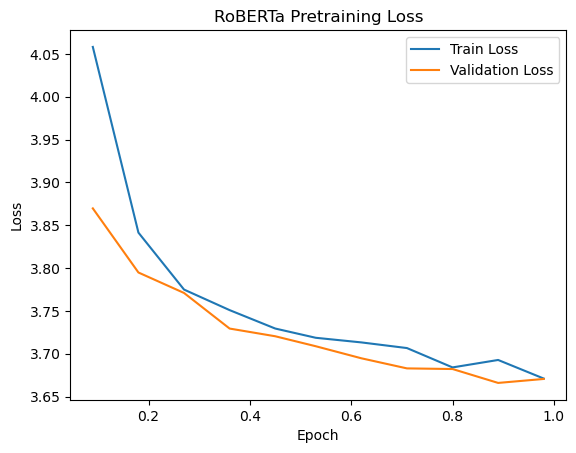

In [36]:
plt.plot(epoch_train_list, train_loss_list)
plt.plot(epoch_eval_list, eval_loss_list)
plt.legend(['Train Loss', 'Validation Loss'])
plt.title("RoBERTa Pretraining Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()